# First, let's load the MNIST dataset

In [97]:
import numpy as np
import matplotlib.pyplot as plt

In [98]:
import requests # for alpha-binary digits

# import torch
# from torchvision import datasets, transforms # for MNIST

### Downloading, preprocessing & loading MNIST

In [99]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST('../data/processed', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# Download and load the test data
testset = datasets.MNIST('../data/processed', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


NameError: name 'transforms' is not defined

In [ ]:
dataiter = iter(trainloader)

In [ ]:
images, labels = dataiter.next()

In [ ]:
print(images.shape, labels.shape) #loading 64 images of shape 28x28

torch.Size([64, 1, 28, 28]) torch.Size([64])


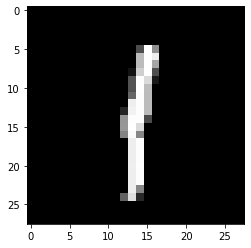

In [ ]:
plt.imshow(images[0].squeeze(), cmap='Greys_r')

---

### Downloading AlphaBinary

In [ ]:
# alpha_binary_mat = requests.get('https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat')

In [ ]:
# with open('../data/raw/alpha_binary.mat', 'wb') as f:
    # f.write(alpha_binary_mat.content)

### Preprocessing AlphaBinary

In [ ]:
import scipy.io

In [ ]:
file_mat = '../data/raw/alpha_binary.mat'
mat = scipy.io.loadmat(file_mat)

In [ ]:
type(mat)

dict

In [ ]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'dat', 'numclass', 'classlabels', 'classcounts'])

In [ ]:
mat['dat'].shape # 39 samples for each of the 36 classes - 10 digits & 26 letters

(36, 39)

In [ ]:
mat['classlabels'][0]

array([array(['0'], dtype='<U1'), array(['1'], dtype='<U1'),
       array(['2'], dtype='<U1'), array(['3'], dtype='<U1'),
       array(['4'], dtype='<U1'), array(['5'], dtype='<U1'),
       array(['6'], dtype='<U1'), array(['7'], dtype='<U1'),
       array(['8'], dtype='<U1'), array(['9'], dtype='<U1'),
       array(['A'], dtype='<U1'), array(['B'], dtype='<U1'),
       array(['C'], dtype='<U1'), array(['D'], dtype='<U1'),
       array(['E'], dtype='<U1'), array(['F'], dtype='<U1'),
       array(['G'], dtype='<U1'), array(['H'], dtype='<U1'),
       array(['I'], dtype='<U1'), array(['J'], dtype='<U1'),
       array(['K'], dtype='<U1'), array(['L'], dtype='<U1'),
       array(['M'], dtype='<U1'), array(['N'], dtype='<U1'),
       array(['O'], dtype='<U1'), array(['P'], dtype='<U1'),
       array(['Q'], dtype='<U1'), array(['R'], dtype='<U1'),
       array(['S'], dtype='<U1'), array(['T'], dtype='<U1'),
       array(['U'], dtype='<U1'), array(['V'], dtype='<U1'),
       array(['W'], dtyp

In [ ]:
labels = np.array([label.item() for label in mat['classlabels'][0]])

In [ ]:
labels

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], dtype='<U1')

---

In [ ]:
images = mat['dat']

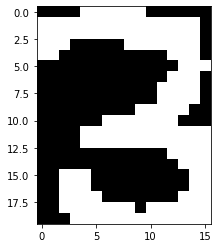

In [ ]:
plt.imshow(images[3][0], cmap='Greys_r')

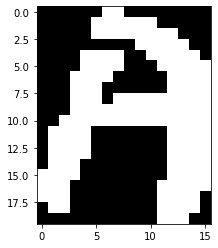

In [ ]:
plt.imshow(images[10][0], cmap='Greys_r')

In [ ]:
labels_array = []

In [ ]:
for index, classe in enumerate(images):
    for image in classe:
        labels_array.append(labels[index])

labels_array = np.array(labels_array)

In [ ]:
labels_array.shape[0] == 36*39

True

In [ ]:
labels_array[0], labels_array[38], labels_array[39]

('0', '0', '1')

---

In [ ]:
images[0][0].flatten().shape

(320,)

In [ ]:
images[0][0].shape

(20, 16)

In [ ]:
def lire_alpha_digit(all_images, classes:list):
    data = []
    for cls in classes:
        for image in all_images[cls]:
            data.append(image.flatten().reshape(-1,1))
    
    return np.array(data)

All our data has been loaded and is ready to be used in a python data environment !

---

# Creating NN classes & methods
### RBM

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
def logistic(x,w,b):
   xw = np.dot(x, w)
   replicated_b = np.tile(b, (x.shape[0], 1))

   return 1.0 / (1 + np.exp(- xw - b))

In [133]:
class RBM:
    
    def __init__(self, n_v, n_h, W=None, b=None, c=None, k=1):
        assert n_v != 0 and n_h != 0
        self.n_v = n_v
        self.n_h = n_h
        shape = (n_h, n_v)
        
        self.W = W if W is not None else np.random.uniform(-1, 1, size=shape)
        self.b = b if b is not None else np.zeros(n_v)
        self.c = c if c is not None else np.zeros(n_h)

        assert self.W.shape==shape and n_v == len(self.b) and n_h == len(self.c)
        
        self.k = k
        return
        
    def forward(self, V):
        n_sample, n_v = V.shape
        
        hsignal = np.dot(V, self.W.T) + self.c
        assert hsignal.shape == (n_sample, self.n_h)
        Hp = sigmoid(hsignal)
        
        #s = np.random.uniform(0, 1, size=hsignal.shape)
        #Hs = (s < Hp) * 1  # same as:
        Hs = np.random.binomial(1, Hp, size=Hp.shape)
        return Hp, Hs
    
    def backward(self, H):
        n_sample, n_h = H.shape
        
        vsignal = np.dot(H, self.W) + self.b
        assert vsignal.shape == (n_sample, self.n_v)
        #print(vsignal)
        Vp = sigmoid(vsignal)
        
        s = np.random.uniform(0, 1, size=vsignal.shape)
        Vs = (s < Vp) * 1
        return Vp, Vs

    def gibbs(self, V):  #return (probability, samples) of visible units
        Vs = V
        for i in range(self.k):
            Hp, Hs = self.forward(Vs)
            Vp, Vs = self.backward(Hs)
            
        return Hp, Hs, Vp, Vs
    
    def contrastive_divergence(self, V, learning=0.01):
        #set_trace()
        n_sample, n_v = V.shape
        
        Vs = V
        Hp, Hs, Vp_, Vs_ = self.gibbs(Vs)   # underscore _ refers to tilde for negative sample
        Hp_, Hs_ = self.forward(Vs_)

        Vs1 = np.mean(Vs, axis=0) 
        Vs2 = np.mean(Vs_, axis=0) 
        Hp1 = np.mean(Hp, axis=0)
        Hp2 = np.mean(Hp_, axis=0)
        Hs1 = np.mean(Hs, axis=0)
        Hs2 = np.mean(Hs_, axis=0)
        
        # note, there are variances in how to compute the gradients.
        # Hugo suggests:     h(v1)*v1 - h(v2)*v2
        # Bengio suggests:   h1*v1 - h(v2)*v2
        # My derivation:     h1(v1)*v1 - h2*v2 
        
        Eh_b = Vs1; Evh_b = Vs2      # Evh_b refers to the Expectation (over v and h) of -logP(v) gradient wrt b
        
        #Eh_c = Hs1; Evh_c = Hp2  # bengio
        Eh_c = Hp1; Evh_c = Hp2  # hugo
        #Eh_c = Hp1; Evh_c = Hs2  # Mine

        g_b = Evh_b - Eh_b  # gradient of -logP(v) wrt b
        g_c = Evh_c - Eh_c

        Eh_W = np.outer(Eh_c, Eh_b) 
        Evh_W = np.outer(Evh_c, Evh_b)
        g_W = Evh_W - Eh_W
    
        self.W -= g_W * learning
        self.b -= g_b * learning
        self.c -= g_c * learning        
        return
    
    def reconstruct(self, V):
        Hp, Hs = self.forward(V)
        Vp, Vs = self.backward(Hp)
        return Vp, Vs
    
    def train_model(self, train_data, n_epoch=100, batch_size=10, learning=0.01):
        for _ in range(n_epoch):
            MSE = []
            data = train_data.copy()
            np.random.shuffle(data)
            for x in data:
                self.contrastive_divergence(x.T, learning)
                reconstructed = self.reconstruct(x.T)
                MSE.append(((x.T - reconstructed)**2).sum()/len(x))
            print(f'MSE for epoch {_}: {np.array(MSE).mean()}')                      
        return
    
    def generate_image(self, iter_gibbs, number_image):
        images = []
        for _ in range(number_image):
            v = np.zeros(self.n_v).reshape(1, -1)
            for _ in range(iter_gibbs):
                _, v = self.reconstruct(v)
            images.append(v)
        return images

---

In [134]:
rbm = RBM(20*16, 20*8)

In [135]:
data = lire_alpha_digit(images, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [136]:
# train_data = list(zip(data, labels_array[:39*3]))

In [137]:
rbm.train_model(data, n_epoch=300)

MSE for epoch 0: 0.42862414419445516
MSE for epoch 1: 0.3868149673138777
MSE for epoch 2: 0.355629045674937
MSE for epoch 3: 0.33011233844999993
MSE for epoch 4: 0.30808886484194054
MSE for epoch 5: 0.2921808626610921
MSE for epoch 6: 0.2801228079630586
MSE for epoch 7: 0.2672422362053826
MSE for epoch 8: 0.2577068530167081
MSE for epoch 9: 0.24911463266255526
MSE for epoch 10: 0.24371127452894767
MSE for epoch 11: 0.23448648842912004
MSE for epoch 12: 0.22973678649721876
MSE for epoch 13: 0.22330127278783965
MSE for epoch 14: 0.21716895417236945
MSE for epoch 15: 0.21191591290179027
MSE for epoch 16: 0.20806601999560523
MSE for epoch 17: 0.2027890008541817
MSE for epoch 18: 0.20070521733759095
MSE for epoch 19: 0.19742639532992734
MSE for epoch 20: 0.1921876392089706
MSE for epoch 21: 0.19052889234678977
MSE for epoch 22: 0.18530924176655023
MSE for epoch 23: 0.181339251235823
MSE for epoch 24: 0.18017156890887784
MSE for epoch 25: 0.17773023114313843
MSE for epoch 26: 0.1753064503564

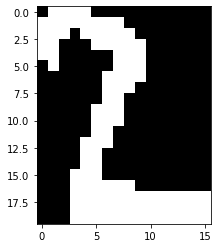

In [138]:
plt.imshow(data[39*2].reshape(20,16), cmap='Greys_r')

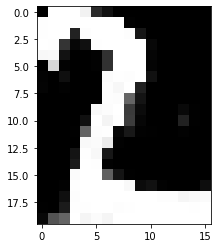

In [139]:
plt.imshow(rbm.reconstruct(data[39*2].T)[0].reshape(20,16), cmap='Greys_r')

In [140]:
generated_images = rbm.generate_image(iter_gibbs=1000, number_image=100)

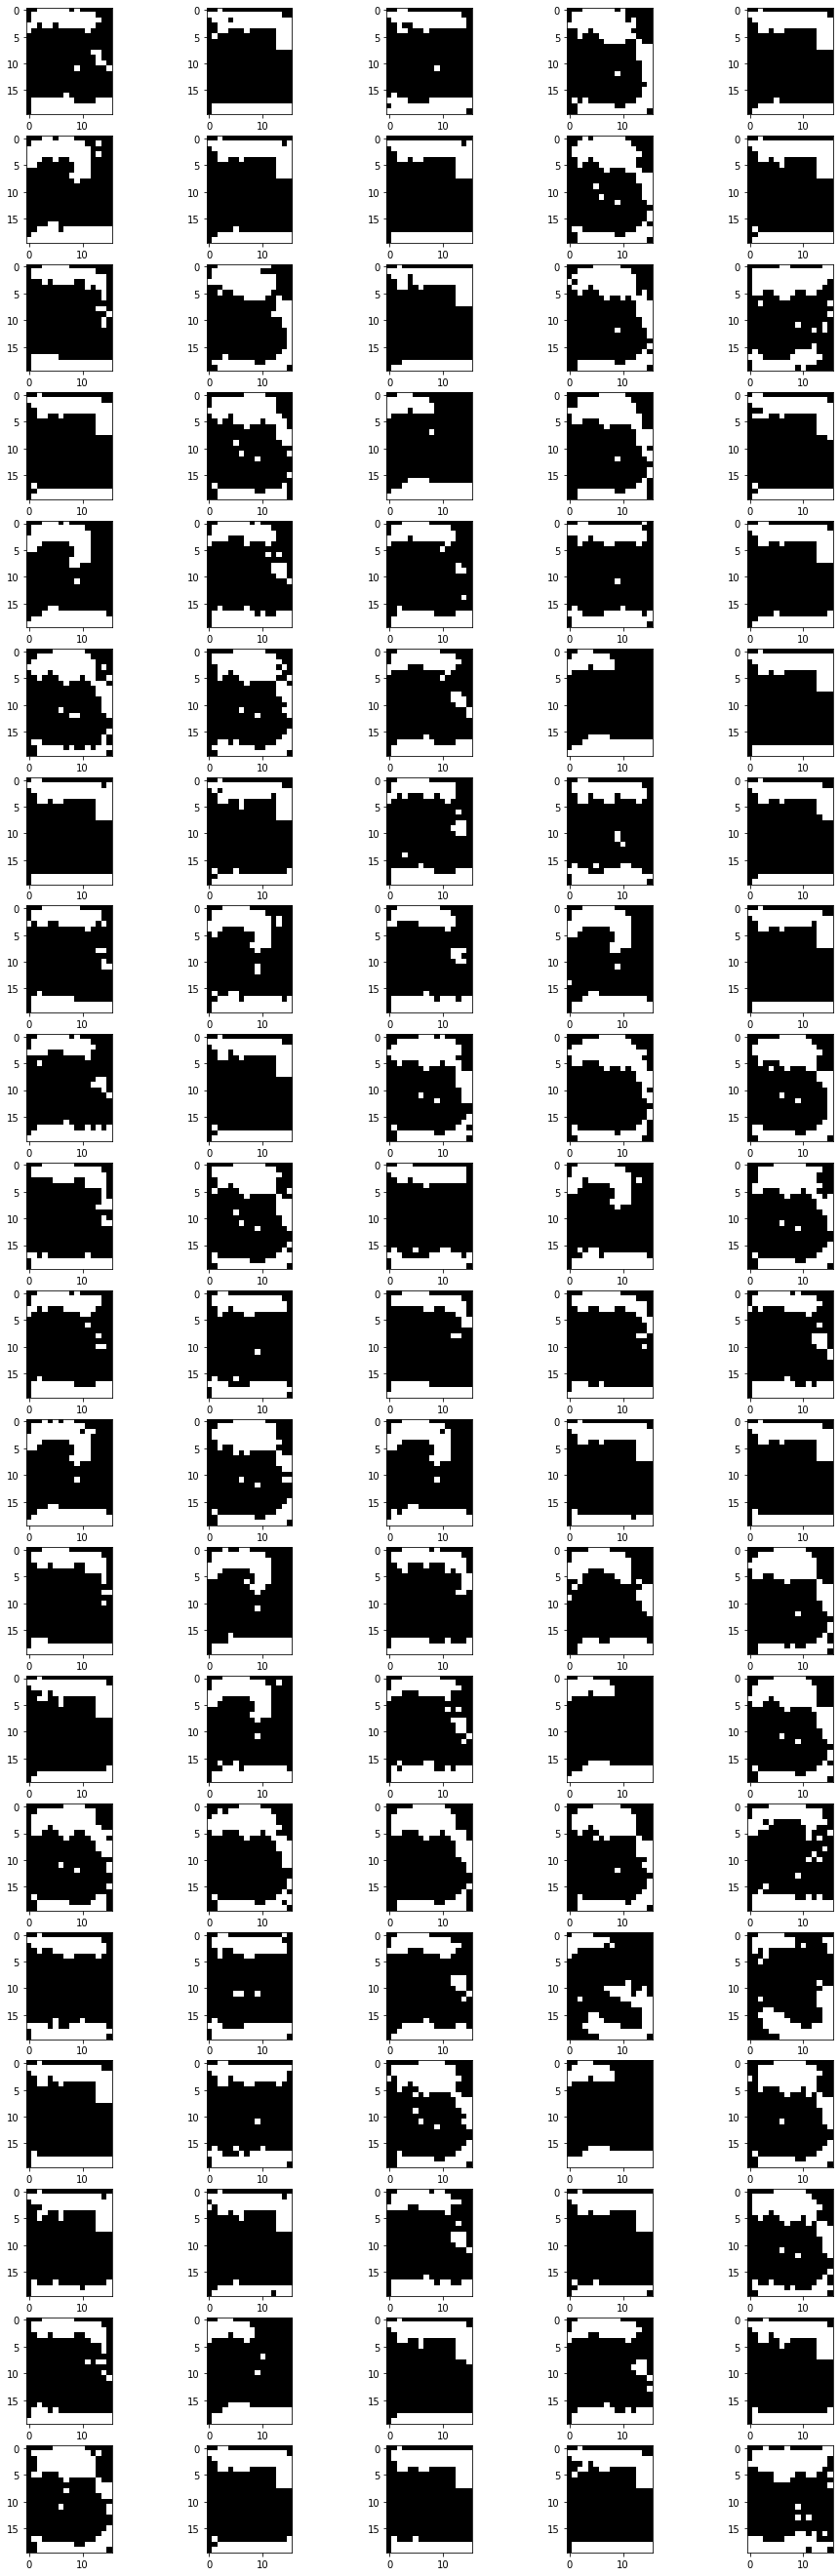

In [164]:
fig = plt.figure(figsize=(16, 48))
columns = 5
rows = 20
for i in range(1, columns*rows +1):
    img = generated_images[i-1].reshape(20,16)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='Greys_r')
plt.show()

In [165]:
def calcul_softmax(rbm:RBM, data):
    h, _ = rbm.forward(data)
    sum_exp = np.exp(h).sum()
    softmax = np.exp(h) / sum_exp
    
    assert softmax.shape == h.shape, 'probability layer should have the same shape as hidden layer'
    assert round(softmax.sum(), 2) == 1.0, 'probabilities should sum to 1'
    
    return softmax

In [166]:
calcul_softmax

---

### DBN

In [149]:
class DBN():
    def __init__(self, n_v, layers, k=1):
        
        if n_v is None or layers is None: raise ValueError("Incorrect inputs for layer 0.")
        
        n_hs = [n_v]        
        n_layer = 0
        
        rbms = []
        for (n_h, model) in layers:
            n_layer += 1
            if n_h <= 0: raise ValueError("Incorrect inputs for layer %d" % (n_layer))
            else: n_hs.append(n_h)

            rbm = RBM(n_hs[n_layer-1], n_h, k=k)
            rbms.append(rbm)

        self.n_hs = n_hs
        self.n_layer = n_layer
        self.rbms = rbms
        return
    
    def forward(self, X):
        
        Hp = X
        for i in range(self.n_layer):
            Hp, Hs = self.rbms[i].forward(Hp)
        
        return Hp, Hs

    def backward(self, H):

        Vp = H
        for i in reversed(range(self.n_layer)):
            Vp, Vs = self.rbms[i].backward(Vp)
        
        return Vp, Vs

    def train_model(self, X, epochs=1, learning=0.01):
        
        for layer in range(self.n_layer):
            self.rbms[layer].train_model(X, n_epoch=epochs, learning=learning)
            X = np.swapaxes((np.array(list(map(lambda x : self.rbms[layer].forward(x.T), X)))[:, 0, :, :]), 1, 2)
        
        return
    
    def reconstruct(self, X):
        h_layer = self.n_layer - 1
        Hp = X
        for i in range(h_layer):
            Hp, Hs = self.rbms[i].forward(Hp)
        
        Vp, Vs = self.rbms[h_layer].reconstruct(Hp)

        for i in reversed(range(h_layer)):
            Hp, Hs = self.rbms[i].backward(Hp)

        return Hp, Hs
    
    def generate_image(self, iter_gibbs, n_images):
        images = []
        for _ in range(n_images):
            v = np.zeros(self.n_hs[0]).reshape(1, -1) # n_hs[0] = n_v first layer
            for _ in range(iter_gibbs):
                _, v = self.reconstruct(v)
            images.append(v)
        return images

In [150]:
n_v = 20*16
h_1 = 20*10
h_2 = 20*8
h_3 = 20*8

layers = [
    (h_1, None),
    (h_2, None),
    # (h_3, None),
]

dbn = DBN(n_v, layers)

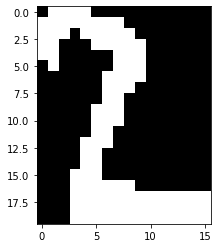

In [151]:
plt.imshow(data[39*2].T.reshape(20,16), cmap='Greys_r')

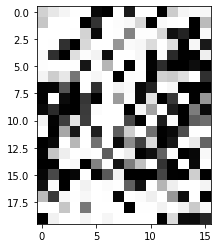

In [152]:
plt.imshow(dbn.reconstruct(data[39*2].T)[0].reshape(20,16), cmap='Greys_r')

In [153]:
dbn.train_model(data, epochs=300)

MSE for epoch 0: 0.39138372200233484
MSE for epoch 1: 0.3491004336053576
MSE for epoch 2: 0.31496987541588684
MSE for epoch 3: 0.294364287895193
MSE for epoch 4: 0.27187045622094996
MSE for epoch 5: 0.25887599689167157
MSE for epoch 6: 0.2457277979613508
MSE for epoch 7: 0.2364229702931839
MSE for epoch 8: 0.22337872767297048
MSE for epoch 9: 0.21672875295472793
MSE for epoch 10: 0.21064614537470075
MSE for epoch 11: 0.2034657283920685
MSE for epoch 12: 0.19474057477968837
MSE for epoch 13: 0.18986319090733508
MSE for epoch 14: 0.1852791038516748
MSE for epoch 15: 0.18042375487044507
MSE for epoch 16: 0.17527742471582505
MSE for epoch 17: 0.17068561633335486
MSE for epoch 18: 0.1684070701785246
MSE for epoch 19: 0.165243533585317
MSE for epoch 20: 0.16037897311634047
MSE for epoch 21: 0.15712369137916743
MSE for epoch 22: 0.15561618204971214
MSE for epoch 23: 0.15096920002790926
MSE for epoch 24: 0.14837739579882817
MSE for epoch 25: 0.14634514632646506
MSE for epoch 26: 0.142841291436

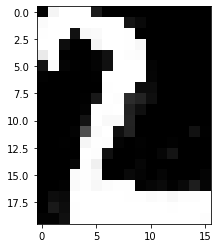

In [154]:
plt.imshow(dbn.reconstruct(data[39*2].T)[0].reshape(20,16), cmap='Greys_r')

In [155]:
generated_images_dbn = dbn.generate_image(1000, 100)

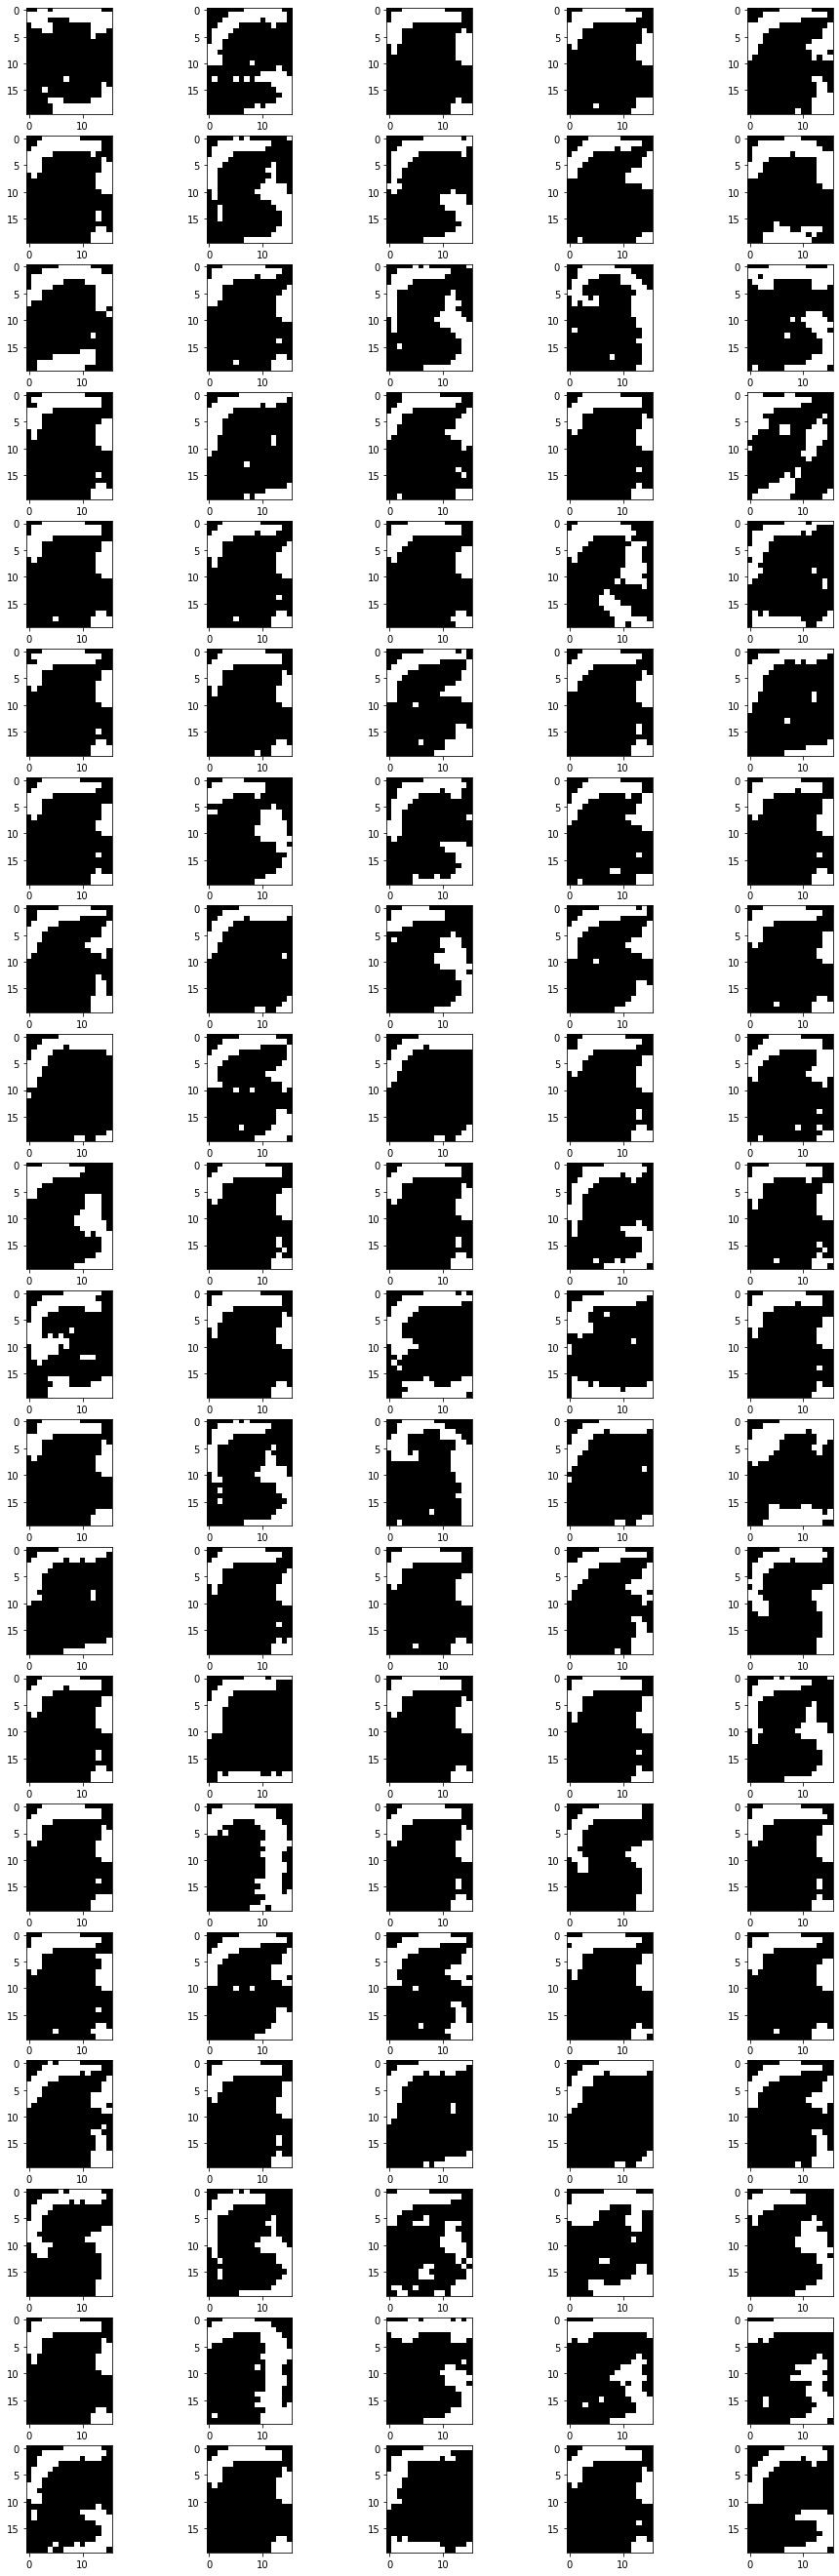

In [163]:
fig = plt.figure(figsize=(16, 48))
columns = 5
rows = 20
for i in range(1, columns*rows +1):
    img = generated_images_dbn[i-1].reshape(20,16)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='Greys_r')
plt.show()